In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor
import json

In [21]:
def compute_gradient(func, inp, **kwargs):
    inp.requires_grad = True

    loss = func(inp, **kwargs)
    loss.backward()

    inp.requires_grad = False

    return inp.grad.data

In [22]:
def read_image(path):
    img = Image.open(path)

    transform = Compose([Resize(256),
                         CenterCrop(224),
                         ToTensor(),
                         Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])])

    tensor_ = transform(img)
    tensor = tensor_.unsqueeze(0)

    return tensor

In [23]:
def to_array(tensor):
    tensor_ = tensor.squeeze()

    unnormalize_transform = Compose([Normalize(mean=[0, 0, 0],
                                               std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                     Normalize(mean=[-0.485, -0.456, -0.406],
                                               std=[1, 1, 1])])
    arr_ = unnormalize_transform(tensor_)
    arr = arr_.permute(1, 2, 0).detach().numpy()

    return arr

In [25]:
def func(inp, net=None, target=None):
    out = net(inp)
    loss = torch.nn.functional.nll_loss(out, target=torch.LongTensor([target]))

    print(f"Loss: {loss.item()}")
    return loss

In [26]:
def attack(tensor, net, eps=1e-3, n_iter=50):
    new_tensor = tensor.detach().clone()

    orig_prediction = net(tensor).argmax()
    print(f"Original prediction: {orig_prediction.item()}")

    for i in range(n_iter):
        net.zero_grad()

        grad = compute_gradient(
                func, new_tensor, net=net, target=orig_prediction.item()
                )
        new_tensor = torch.clamp(new_tensor + eps * grad.sign(), -2, 2)
        new_prediction = net(new_tensor).argmax()

        if orig_prediction != new_prediction:
            print(f"We fooled the network after {i} iterations!")
            print(f"New prediction: {new_prediction.item()}")
            break

    return new_tensor, orig_prediction.item(), new_prediction.item()

In [31]:
!wget https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json -O imagenet_class_index.json

with open('imagenet_class_index.json') as f:
    class_names = json.load(f)

--2024-05-31 17:06:29--  https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14209 (14K) [text/plain]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  13.88K  --.-KB/s    in 0.001s  

2024-05-31 17:06:29 (24.6 MB/s) - ‘imagenet_class_index.json’ saved [14209/14209]



In [28]:
net = models.resnet18(pretrained=True)
net.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
!gdown 1WWhY6J0Cq94x7N4yiqyaHOcyEI-bYEoB

Downloading...
From: https://drive.google.com/uc?id=1WWhY6J0Cq94x7N4yiqyaHOcyEI-bYEoB
To: /content/img.zip
100% 375k/375k [00:00<00:00, 97.2MB/s]


In [19]:
!unzip img.zip

Archive:  img.zip
  inflating: img1.jpg                
  inflating: img2.jpg                
  inflating: img3.jpg                
  inflating: img4.jpg                
  inflating: img5.jpg                


Original prediction: 1
Loss: -16.58420753479004
Loss: -14.238237380981445
Loss: -11.908235549926758
Loss: -9.899093627929688
Loss: -8.044139862060547


We fooled the network after 4 iterations!
New prediction: 955
Original prediction: 13
Loss: -19.884450912475586
Loss: -18.2287654876709
Loss: -16.428953170776367
Loss: -14.792369842529297
Loss: -13.313091278076172
Loss: -11.98434066772461
Loss: -10.811453819274902
Loss: -9.761312484741211
Loss: -8.793752670288086
Loss: -7.918900966644287
Loss: -7.145185470581055
Loss: -6.408372402191162
Loss: -5.7076239585876465
Loss: -5.056273460388184
We fooled the network after 13 iterations!
New prediction: 693
Original prediction: 767
Loss: -10.380701065063477


We fooled the network after 0 iterations!
New prediction: 593
Original prediction: 966
Loss: -15.038214683532715
Loss: -14.604515075683594
Loss: -13.58262825012207


We fooled the network after 2 iterations!
New prediction: 907
Original prediction: 579
Loss: -29.086833953857422
Loss: -27.136798858642578
Loss: -24.77518081665039
Loss: -22.587255477905273
Loss: -20.542118072509766
Loss: -18.665918350219727
Loss: -16.949478149414062
Loss: -15.34228229522705
Loss: -13.749836921691895
Loss: -12.178075790405273
Loss: -10.653338432312012
Loss: -9.22911262512207
Loss: -7.976321220397949


We fooled the network after 12 iterations!
New prediction: 881


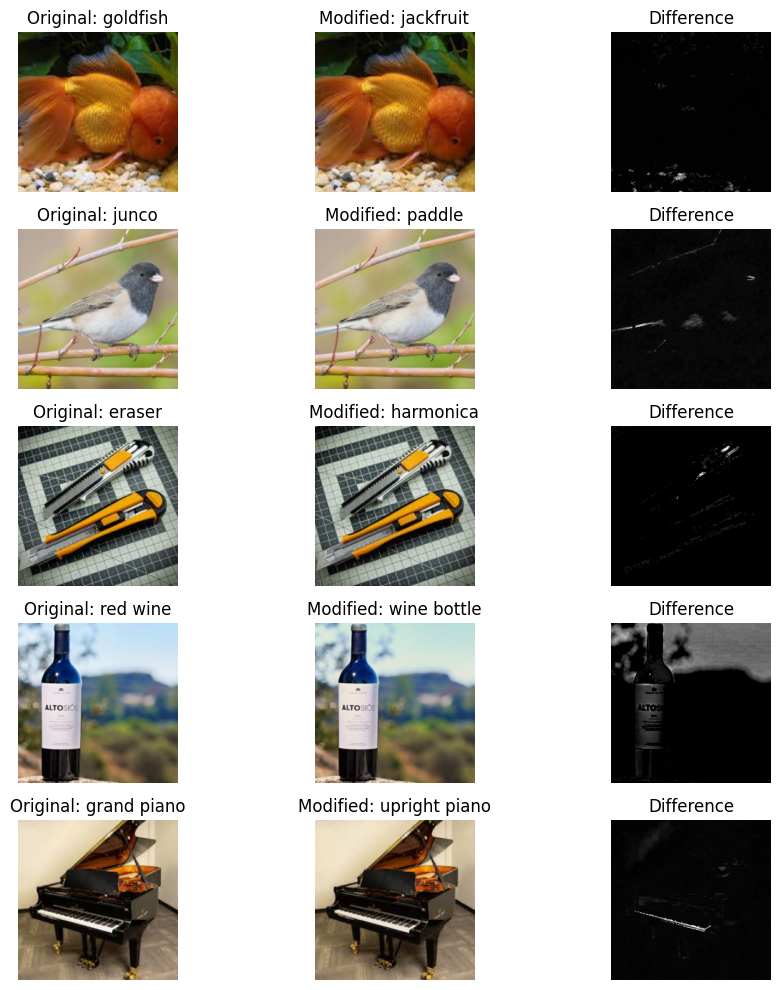

In [35]:
image_files = ['img1.jpg', 'img2.jpg', 'img3.jpg', 'img4.jpg', 'img5.jpg']

plt.figure(figsize=(10, 10))

for i, image_file in enumerate(image_files):
    tensor = read_image(image_file)

    new_tensor, orig_prediction, new_prediction = attack(
            tensor, net, eps=1e-3, n_iter=100
            )

    arr = to_array(tensor)
    new_arr = to_array(new_tensor)
    diff_arr = np.abs(arr - new_arr).mean(axis=-1)
    diff_arr = diff_arr / diff_arr.max()

    ax_orig = plt.subplot(5, 3, i * 3 + 1)
    ax_new = plt.subplot(5, 3, i * 3 + 2)
    ax_diff = plt.subplot(5, 3, i * 3 + 3)

    ax_orig.imshow(arr)
    ax_new.imshow(new_arr)
    ax_diff.imshow(diff_arr, cmap="gray")

    ax_orig.axis("off")
    ax_new.axis("off")
    ax_diff.axis("off")

    ax_orig.set_title(f"Original: {class_names[orig_prediction]}")
    ax_new.set_title(f"Modified: {class_names[new_prediction]}")
    ax_diff.set_title("Difference")

plt.tight_layout()
plt.show()